### Transfer Learning EfficientNet détourage et recadrage 256x256

In [2]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.efficientnet import preprocess_input


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB1
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [3]:
data = pd.read_csv('../files_detour_256.csv',index_col=0)

In [4]:
src_img = '../images_detour_256/'

In [5]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [6]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [7]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [8]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour_256/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour_256/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour_256/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour_256/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour_256/BA_102750.jpg,BA_102750.jpg,basophil,0


In [9]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [10]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [256,256]) / déjà redimensionné par detourage
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # Preproccess efficientNet
    return img

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [13]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [14]:
# Création d'un modèle MobileNet
def model_efficientNet():
    base_model = EfficientNetB1(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.2)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = model_efficientNet()

In [16]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 2852s 4s/step - loss: 0.6506 - accuracy: 0.7834 - val_loss: 0.4478 - val_accuracy: 0.8615
Epoch 2/16
800/800 [==============================] - 2818s 4s/step - loss: 0.4860 - accuracy: 0.8411 - val_loss: 0.4359 - val_accuracy: 0.8580
Epoch 3/16
800/800 [==============================] - 2723s 3s/step - loss: 0.4484 - accuracy: 0.8567 - val_loss: 0.3779 - val_accuracy: 0.8756
Epoch 4/16
800/800 [==============================] - 2863s 4s/step - loss: 0.4198 - accuracy: 0.8628 - val_loss: 0.3583 - val_accuracy: 0.8872
Epoch 5/16
800/800 [==============================] - 2710s 3s/step - loss: 0.4026 - accuracy: 0.8699 - val_loss: 0.3689 - val_accuracy: 0.8826
Epoch 6/16
800/800 [==============================] - 2713s 3s/step - loss: 0.3852 - accuracy: 0.8751 - val_loss: 0.3679 - val_accuracy: 0.8844
Epoch 7/16
800/800 [==============================] - 2713s 3s/step - loss: 0.3743 - accuracy: 0.8774 - val_loss: 0.3610 - val_accuracy:

In [17]:
model.save_weights("efficientnet_10_detour_weights")

#### Prédiction sur les données d'évaluation

In [15]:
# model.load_weights("efficientnet_10_detour_weights")

In [18]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [19]:
model.evaluate(dataset_eval)

99/99 [==============================] - 297s 3s/step - loss: 0.3484 - accuracy: 0.8874


[0.34840986132621765, 0.8873774409294128]

 * Pas d'amélioration avec détourage : 89%

#### Fine Tunning

In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

block6e_se_reduce (Conv2D)      (None, 1, 1, 48)     55344       block6e_se_reshape[0][0]         
__________________________________________________________________________________________________
block6e_se_expand (Conv2D)      (None, 1, 1, 1152)   56448       block6e_se_reduce[0][0]          
__________________________________________________________________________________________________
block6e_se_excite (Multiply)    (None, 8, 8, 1152)   0           block6e_activation[0][0]         
                                                                 block6e_se_expand[0][0]          
__________________________________________________________________________________________________
block6e_project_conv (Conv2D)   (None, 8, 8, 192)    221184      block6e_se_excite[0][0]          
__________________________________________________________________________________________________
block6e_project_bn (BatchNormal (None, 8, 8, 192)    768         block6e_project_conv[0][0]       
__________

In [21]:
# Unfreeze dernier block Efficient 7b
for layer in model.layers[-26:]:
    layer.trainable = True

In [22]:
model.compile(optimizer=Adam(learning_rate=1e-4) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3)

In [24]:
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[reduce_lr,early_stopping])

Epoch 1/16
800/800 [==============================] - 3180s 4s/step - loss: 0.4041 - accuracy: 0.8684 - val_loss: 0.3360 - val_accuracy: 0.8931
Epoch 2/16
800/800 [==============================] - 3152s 4s/step - loss: 0.3302 - accuracy: 0.8915 - val_loss: 0.3281 - val_accuracy: 0.8917
Epoch 3/16
800/800 [==============================] - 3161s 4s/step - loss: 0.2994 - accuracy: 0.9017 - val_loss: 0.3081 - val_accuracy: 0.8949
Epoch 4/16
800/800 [==============================] - 3181s 4s/step - loss: 0.2749 - accuracy: 0.9066 - val_loss: 0.3169 - val_accuracy: 0.9019
Epoch 5/16
800/800 [==============================] - 3162s 4s/step - loss: 0.2510 - accuracy: 0.9160 - val_loss: 0.3186 - val_accuracy: 0.8963
Epoch 6/16
800/800 [==============================] - 3180s 4s/step - loss: 0.2355 - accuracy: 0.9209 - val_loss: 0.3213 - val_accuracy: 0.8991
Epoch 7/16
800/800 [==============================] - 3167s 4s/step - loss: 0.1950 - accuracy: 0.9341 - val_loss: 0.3087 - val_accuracy:

In [25]:
model.save_weights("efficientnet_10_weights")

#### Evaluation des résultats

In [26]:
model.evaluate(dataset_eval)

99/99 [==============================] - 298s 3s/step - loss: 0.3210 - accuracy: 0.8984


[0.32104676961898804, 0.8984498381614685]

In [27]:
# Pas d'amélioration avec le détourage 90%

In [28]:
#Classes prédites
predict = model.predict(dataset_eval)

In [29]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.94      0.91      0.92       118
       blast       0.82      0.86      0.83       325
  eosinophil       0.99      0.97      0.98       320
erythroblast       0.99      0.88      0.93       217
          ig       0.85      0.77      0.81       386
  lymphocyte       0.90      0.94      0.92       467
    monocyte       0.80      0.83      0.81       264
  neutrophil       0.96      0.97      0.96       580
    platelet       1.00      1.00      1.00       231
      smudge       0.76      0.82      0.79       253

    accuracy                           0.90      3161
   macro avg       0.90      0.89      0.90      3161
weighted avg       0.90      0.90      0.90      3161



> Gain de 1% en fine tunning seulement

In [31]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,107,0,0,0,9,2,0,0,0,0
blast,0,278,0,0,3,8,20,0,0,16
eosinophil,0,0,309,0,2,0,0,4,0,5
erythroblast,1,0,0,192,7,12,1,2,0,2
ig,2,34,0,0,299,7,19,10,0,15
lymphocyte,1,5,1,2,7,438,2,0,0,11
monocyte,0,12,0,0,7,6,219,4,0,16
neutrophil,0,0,2,0,11,1,4,560,0,2
platelet,0,0,0,0,0,0,0,0,231,0


> Confusion importante blaste/IG ainsi que monocyte/IG

In [32]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [33]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

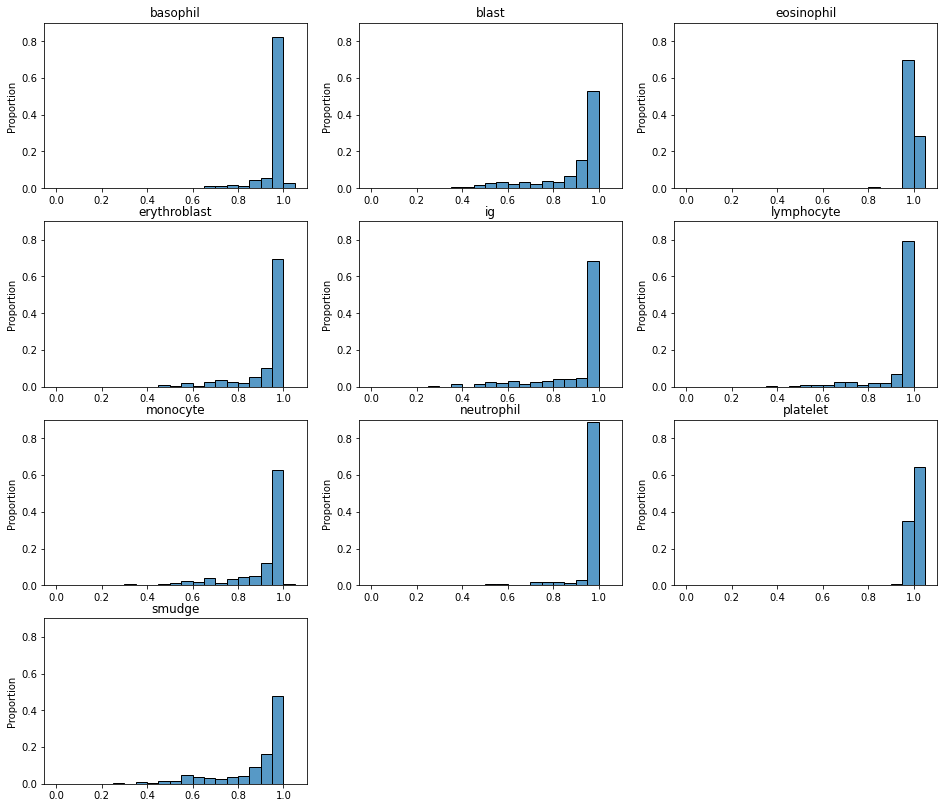

In [34]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> % de prédiction plus important : prédiction plus sûre

In [53]:
# Cellule mal prédite => % sur la classe choisie
predict_incorrect = compare[compare['Réalité']!=compare['Prédiction']]
pourcent_incorrect = predict[predict_incorrect.index].max(axis = 1)

<AxesSubplot:ylabel='Proportion'>

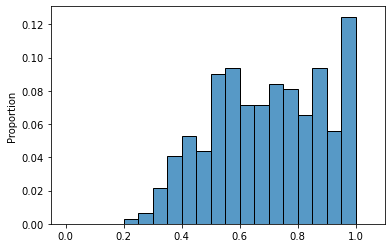

In [65]:
fig = plt.figure(figsize=(6,4))
sns.histplot(x=pourcent_incorrect,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Prédiction dans la mauvaise classe avec un score souvent supérieur à 50% => ne peut pas exclure selon un taux de pourcentage


### GRAD CAM

In [35]:
import gradcam_dataset

In [36]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [37]:
img_size = (256, 256)
last_conv_layer_name = "top_conv"

##### BASOPHIL

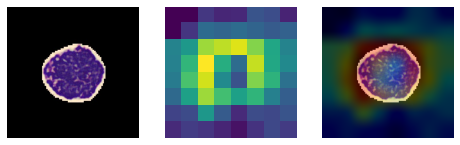

In [40]:
path = data[data['filename']=='BA_23839.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

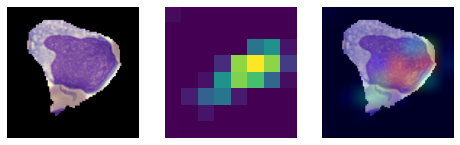

In [41]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

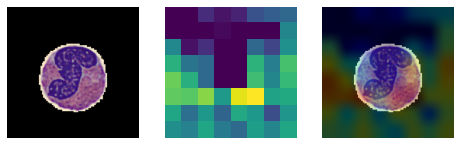

In [42]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

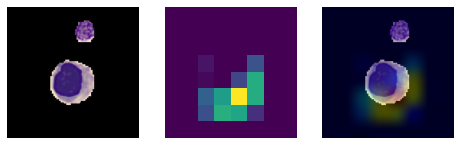

In [45]:
path = data[data['filename']=='ERB_20749.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

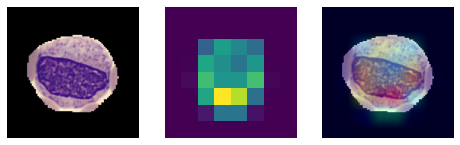

In [46]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

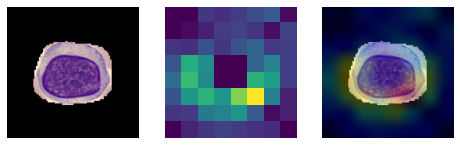

In [48]:
path = data[data['filename']=='LY_78141.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

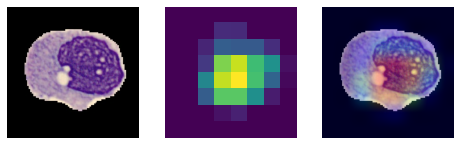

In [49]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

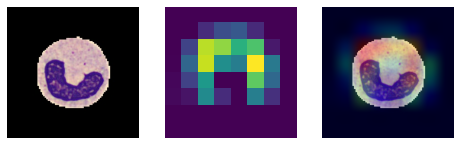

In [50]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

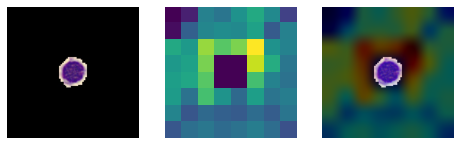

In [51]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

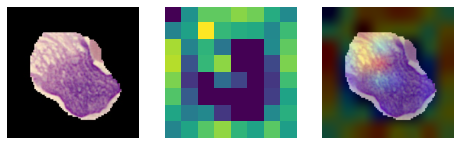

In [52]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)